## PPG Preprocessing

This notebook loads the PPGBP data dataset, and then applies preprocessing steps with the help of `pyPPG` and the `qppg` beat detection algorithm from the physionet Physionet Cardiovascular Signal Toolbox. Preprocessing steps include:

1. Chebyshev bandpass filter to remove noise, 
2. Signal derivatives (1st, 2nd, and 3rd)
3. Segment pulses using QPPG beat detection algorithm
4. Find fiducial points in the signal and derivatives
5. Process the fiducial points into biomarkers

Data is saved after step 3 and 5 for follow-on analyses of blood pressure prediction using CNN and other machine learning algorithms in separate notebooks. This is mainly because other up-to-date libraries like `PyTorch` and `sklearn` or more stable in an environment with a newer Python version.

## References

pyPPG library: https://pyppg.readthedocs.io/

Goda, Márton Áron, Peter H. Charlton and Joachim A. Behar. “pyPPG: a Python toolbox for comprehensive photoplethysmography signal analysis.” Physiological Measurement 45 (2023)

QPPG beat detection: https://physionet.org/content/pcst/1.0.0/

Vest, Adriana Nicholson, Giulia Da Poian, Qiao Li, Chengyu Liu, Shamim Nemati, Amit J. Shah and Gari D. CliQord. “An open source benchmarked toolbox for cardiovascular waveform and interval analysis.” Physiological Measurement 39 (2018)

## Environment Requirements:

`pyPPG` requires Python 3.10, which also installs a specific version of `numpy`, and is not compatible with newer versions. It is recommended to create a new python environmentusing `conda` with the following steps. The new python environment is named “py310” below, but it could be any name.

**Step 1** conda create -n py310 python=3.10

**Step 2** conda activate py310

**Step 3** pip install --no-build-isolation pyppg

**Step 4** pip install openpyxl

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyPPG import Fiducials
from scipy.signal import decimate
from tqdm import tqdm        
import PPG_to_BP_lib as ppg_bp

In [6]:
#data summary table includes subject characteristics and Blood Pressure values
data_summary = pd.read_excel('./data/PPGBP/Data File/PPG-BP dataset.xlsx',header=1)
data_summary

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.268006,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.284799,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.888889,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.971336,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.055151,Prehypertension,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,215,415,Male,24,180,70,111,70,77,21.604938,Normal,NaN,NaN,NaN
215,216,416,Female,25,156,47,93,57,79,19.312952,Normal,NaN,NaN,NaN
216,217,417,Male,25,176,55,120,69,72,17.755682,Prehypertension,NaN,NaN,NaN
217,218,418,Male,25,173,63,106,69,67,21.049818,Normal,NaN,NaN,NaN


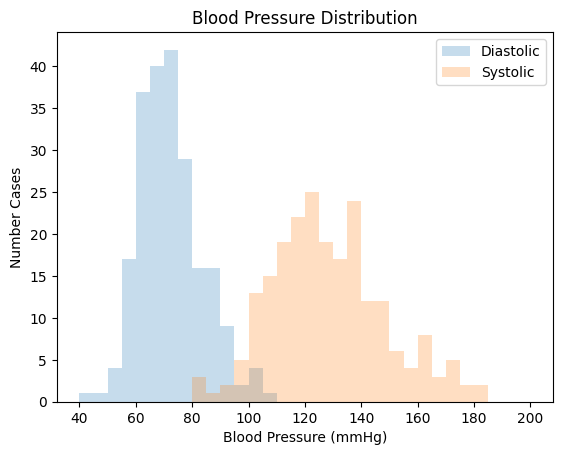

In [7]:
# Plot Blood Pressure Distribution
plt.hist(data_summary['Diastolic Blood Pressure(mmHg)'],alpha=.25,label='Diastolic',bins=np.linspace(40,200,33))
plt.hist(data_summary['Systolic Blood Pressure(mmHg)'],alpha=.25,label='Systolic',bins=np.linspace(40,200,33))
plt.ylabel('Number Cases')
plt.xlabel('Blood Pressure (mmHg)')
plt.legend()
plt.title('Blood Pressure Distribution')
plt.show()
# plt.savefig('PPGBP_BP.png')

In [8]:
## create study structure

data_dir = './data/PPGBP/Data File/0_subject/'
fs = 1000 #original sampling frequency

id_array = [] #file ID array
ppg_array = [] #raw PPG signal array
sbp_array = [] #SBP value array
dbp_array = [] #DBP value array
segment_ids = ['1','2','3'] #each subject has 3 segments

# load data
for subj_idx in tqdm(range(len(data_summary))):

    for seg_id in segment_ids:

        file_id = str(data_summary['subject_ID'].iloc[subj_idx]) + '_' + seg_id
        data,time_sec = ppg_bp.load_signal_PPGBP(file_id, data_dir, fs)
        data = data[:-1]

        id_array.append(file_id)
        ppg_array.append(data)

        sbp_array.append(data_summary['Systolic Blood Pressure(mmHg)'].iloc[subj_idx])
        dbp_array.append(data_summary['Diastolic Blood Pressure(mmHg)'].iloc[subj_idx])

100%|██████████| 219/219 [00:09<00:00, 24.20it/s]


## Preprocessing

- Bandpass filters and signal derivatives using pyPPG library
- Beat detection with qppg algorithm


In [9]:
# preprocess with pyPPG
fs = 1000
ds_ratio = 8
ds_fs = fs / ds_ratio
ds_fs = int(ds_fs)

valleys_list = [] #list of valley locations for each segment
s_list = [] #list of preprocessed signals for each segment

for i in tqdm(range(len(id_array))):

    signal_temp = ppg_array[i]
    # normalize signal:
    signal_temp = 1000*(signal_temp - signal_temp.min()) / (signal_temp.max() - signal_temp.min()) 
    
    # filter parameters
    fL=0.5000001 # Lower cutoff frequency (Hz)
    fH=12 # Upper cutoff frequency (Hz)
    order=2 # Filter order
    # sm_wins={'ppg':50,'vpg':20,'apg':20,'jpg':20} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"
    sm_wins={'ppg':20,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

    # preprocess
    s = ppg_bp.preprocess_ppgbp(signal_temp,fs,id_array[i],fL,fH,order,sm_wins)
    # downsample
    downsampled_signal = decimate(s.ppg, ds_ratio)
    # detect valleys (pulse onsets)
    valleys=ppg_bp.qppg(downsampled_signal,ds_fs,1,len(downsampled_signal))
    valleys_fs = np.array(valleys)*8

    # store results
    valleys_list.append(valleys_fs.astype(int))
    s_list.append(s)

100%|██████████| 657/657 [00:03<00:00, 201.33it/s]


## Store data in a .mat file

...which can be used in another environment with current version of PyTorch

In [10]:
ppg_list = []
vpg_list = []
apg_list = []
jpg_list = []
id_list = []
sbp_list = []
dbp_list = []

for i in tqdm(range(len(id_array))):

    pulse = list(range(len(valleys_list[i])-1))
    if len(pulse)<1:
        continue
    
    for p in pulse:

        onsets = np.array(valleys_list[i][p:(p+2)])

        s_temp = s_list[i]
        
        ppg_list.append(s_temp.ppg[onsets[0]:onsets[1]])
        vpg_list.append(s_temp.vpg[onsets[0]:onsets[1]])
        apg_list.append(s_temp.apg[onsets[0]:onsets[1]])
        jpg_list.append(s_temp.jpg[onsets[0]:onsets[1]])

        id_list.append(id_array[i])
        sbp_list.append(sbp_array[i])
        dbp_list.append(dbp_array[i])

    
ppg_mat = {'id':id_list,
           'sbp': sbp_list,
           'dbp':dbp_list,
           'ppg':ppg_list,
           'vpg':vpg_list,
           'apg':apg_list,
           'jpg':jpg_list}

from scipy.io import savemat
savemat('ppg_signals.mat', ppg_mat)

100%|██████████| 657/657 [00:00<00:00, 41217.81it/s]
/opt/anaconda3/envs/p310/lib/python3.10/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


## Fiducial Points

In [11]:
#we need to store the IDs, SBP, and DBP values corresponding to the biomarker dataframe
#because some segments may be excluded due to missing or invalid fiducial points
id_array_fp = []
sbp_array_fp = []
dbp_array_fp = []

s_list_fp = []
fp_list = []
for i in tqdm(range(len(id_array))):

    pulse = list(range(len(valleys_list[i])-1))
    if len(pulse)<1:
        continue
    
    for p in pulse:

        onsets = np.array(valleys_list[i][p:(p+2)])

        s_temp = s_list[i]
        
        det_fp = ppg_bp.find_fiducials(s_temp,onsets)

        fp_list.append(det_fp)
        
        id_array_fp.append(id_array[i])
        s_list_fp.append(s_temp)

        sbp_array_fp.append(sbp_array[i])
        dbp_array_fp.append(dbp_array[i])


fiducial_df = pd.concat(fp_list)

# in some cases, dp or w are not found, replace with dn+1

mask = fiducial_df['dp'].isna()
fiducial_df.loc[mask, 'dp'] = fiducial_df.loc[mask, 'dn'] + 1

mask = fiducial_df['w'].isna()
fiducial_df.loc[mask, 'w'] = fiducial_df.loc[mask, 'dn'] + 1

100%|██████████| 657/657 [00:07<00:00, 86.81it/s] 


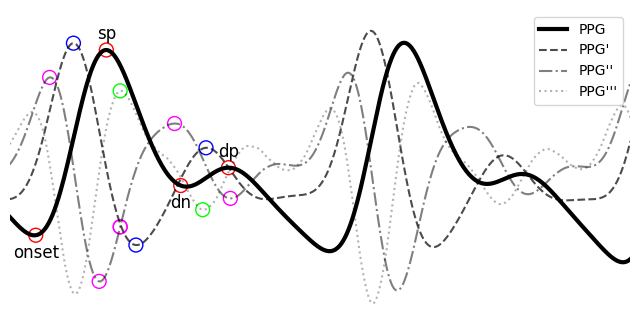

In [12]:
# Make cool sample plot for blog post

idx = 1197
fp = Fiducials(pd.DataFrame(fiducial_df.iloc[idx]).T)
#set figure size to be wide
plt.figure(figsize=(8,4))

#first plot PPG and its derivatives. Scale each to its own range for better visualization
ppg_scale = np.max(s_list_fp[idx].ppg) - np.min(s_list_fp[idx].ppg)
plt.plot(s_list_fp[idx].ppg/ppg_scale,label='PPG',color='black',linewidth=3)
vpg_scale = np.max(s_list_fp[idx].vpg) - np.min(s_list_fp[idx].vpg)
plt.plot(s_list_fp[idx].vpg/vpg_scale,linestyle='--',color='black',alpha=.7,label="PPG'")
apg_scale = np.max(s_list_fp[idx].apg) - np.min(s_list_fp[idx].apg)
plt.plot(s_list_fp[idx].apg/apg_scale,linestyle='-.',color='black',alpha=.5,label="PPG''")
jpg_scale = np.max(s_list_fp[idx].jpg) - np.min(s_list_fp[idx].jpg)
plt.plot(s_list_fp[idx].jpg/jpg_scale,linestyle=':',color='black',alpha=.3,label="PPG'''")

# plot fiducial points with labels on the ppg
plt.scatter(fp.sp, s_list_fp[idx].ppg[int(fp.sp)]/ppg_scale, color='red',marker='o',s=100,facecolors='none')
plt.text(fp.sp, s_list_fp[idx].ppg[int(fp.sp)]/ppg_scale + 0.05, 'sp', fontsize=12, ha='center')
plt.scatter(fp.dp, s_list_fp[idx].ppg[int(fp.dp)]/ppg_scale, color='red',marker='o',s=100,facecolors='none')
plt.text(fp.dp, s_list_fp[idx].ppg[int(fp.dp)]/ppg_scale + 0.05, 'dp', fontsize=12, ha='center')
plt.scatter(fp.dn, s_list_fp[idx].ppg[int(fp.dn)]/ppg_scale, color='red',marker='o',s=100,facecolors='none')
plt.text(fp.dn, s_list_fp[idx].ppg[int(fp.dn)]/ppg_scale - 0.1, 'dn', fontsize=12, ha='center')
plt.scatter(fp.on, s_list_fp[idx].ppg[int(fp.on)]/ppg_scale, color='red',marker='o',s=100,facecolors='none')
plt.text(fp.on, s_list_fp[idx].ppg[int(fp.on)]/ppg_scale - 0.1, 'onset', fontsize=12, ha='center')

# plot fiducial points on the first derivative (vpg)
plt.scatter(fp.u, s_list_fp[idx].vpg[int(fp.u)]/vpg_scale, color='blue',marker='o',s=100,facecolors='none')
plt.scatter(fp.v, s_list_fp[idx].vpg[int(fp.v)]/vpg_scale, color='blue',marker='o',s=100,facecolors='none')
plt.scatter(fp.w, s_list_fp[idx].vpg[int(fp.w)]/vpg_scale, color='blue',marker='o',s=100,facecolors='none')

# plot fiducial points on the second derivative (apg)
plt.scatter(fp.a, s_list_fp[idx].apg[int(fp.a)]/apg_scale, color='magenta',marker='o',s=100,facecolors='none')
plt.scatter(fp.b, s_list_fp[idx].apg[int(fp.b)]/apg_scale, color='magenta',marker='o',s=100,facecolors='none')
plt.scatter(fp.c, s_list_fp[idx].apg[int(fp.c)]/apg_scale, color='magenta',marker='o',s=100,facecolors='none')
plt.scatter(fp.d, s_list_fp[idx].apg[int(fp.d)]/apg_scale, color='magenta',marker='o',s=100,facecolors='none')
plt.scatter(fp.e, s_list_fp[idx].apg[int(fp.e)]/apg_scale, color='magenta',marker='o',s=100,facecolors='none')
plt.scatter(fp.f, s_list_fp[idx].apg[int(fp.f)]/apg_scale, color='magenta',marker='o',s=100,facecolors='none')

# plot fiducial points on the third derivative (jpg)
plt.scatter(fp.p1, s_list_fp[idx].jpg[int(fp.p1)]/jpg_scale, color='lime',marker='o',s=100,facecolors='none')
plt.scatter(fp.p2, s_list_fp[idx].jpg[int(fp.p2)]/jpg_scale, color='lime',marker='o',s=100,facecolors='none')

ax = plt.gca()
ax.set_frame_on(False)

plt.xlim([50,1350])
plt.yticks([])
plt.xticks([])
plt.legend()

plt.savefig('PPGBP_fiducials_example.png',dpi=300)

## Biomarkers

In [16]:
#we need to store the IDs, SBP, and DBP values corresponding to the biomarker dataframe
#because some segments may be excluded due to missing or invalid fiducial points
id_array_bio = []
sbp_array_bio = []
dbp_array_bio = []

for i in tqdm(range(len(id_array_fp))):

    fp = pd.DataFrame(fiducial_df.iloc[i]).T.astype(int)

    df_bio_temp = ppg_bp.find_biomarkers(s_list_fp[i],fp)

    if df_bio_temp.isna().sum().sum():
        continue
    if np.isinf(df_bio_temp.to_numpy()).sum():
        continue
    
    if (i == 0):
        df_bio = df_bio_temp
    else:
        df_bio = pd.concat([df_bio,df_bio_temp],axis=0)

    id_array_bio.append(id_array_fp[i])
    sbp_array_bio.append(sbp_array_fp[i])
    dbp_array_bio.append(dbp_array_fp[i])

df_bio['id'] = id_array_bio
df_bio['sbp'] = sbp_array_bio
df_bio['dbp'] = dbp_array_bio

100%|██████████| 1264/1264 [00:05<00:00, 239.98it/s]


In [ ]:
#save biomarkers to csv
df_bio.to_csv('biomarkers_PPGBP.csv',index=False)